In [1]:
%run ../SAMI/utils.py
%run ../SAMI/preprocessing.py
%run ../SAMI/correlation.py
%run ../SAMI/clustering.py
%run ../SAMI/markers.py
%run ../SAMI/pathway.py
%run ../SAMI/norm.py
%run ../SAMI/clustermapping.py
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

## Normalization

In [3]:
data_path = '../datasets/'
for file in os.listdir(data_path):
    name, ext = os.path.splitext(file)
    if re.match(r'^\w+raw\.csv',file):
        df = pd.read_csv(os.path.join(data_path,f"{file}"))
        df_norm = Normalization(df, first_compound_idx=3, rowNorm='SumNorm', transNorm='LogTrans2', c=1, log_base=2)
        name = name.replace('raw','norm')
        df_norm.to_csv(os.path.join(data_path,f"{name}{ext}"),index=False)

Normalization to constant sum 1.
Log2 Transformation.
Scaling: N/A.
Normalization to constant sum 1.
Log2 Transformation.
Scaling: N/A.
Normalization to constant sum 1.
Log2 Transformation.
Scaling: N/A.


## Convert .csv to .h5ad and split datasets by regions

In [4]:
csv2h5ad(data_path=data_path,pattern=r'^\w+norm\.csv',split=True)

## Pool three omics data

In [5]:
pooldata(data_path=data_path,pattern=r'^\w+norm\.csv',split=True) 

In [6]:
list_files(data_path,'pool','.h5ad')

['brain1_pool.h5ad', 'brain2_pool.h5ad', 'brain_pool.h5ad']

# Correlation Investigation

In [7]:
adata1=sc.read(os.path.join(data_path,'brain2_metabolomics.h5ad'))
adata2=sc.read(os.path.join(data_path,'brain2_lipidomics.h5ad'))

In [8]:
corr = calculate_corr(adata1,adata2)

In [27]:
indexed_values = list(enumerate(corr['corr'].tolist()))

sorted_values = sorted(indexed_values, key=lambda x: x[1])

smallest_two_indices = [item[0] for item in sorted_values[:2]]

biggest_two_indices = [item[0] for item in sorted_values[-2:]]

middle_two_indices = [item[0] for item in sorted_values[len(sorted_values)//2:len(sorted_values)//2+2]]

subcorr = corr.iloc[smallest_two_indices+biggest_two_indices+middle_two_indices,]
subcorr.to_csv(os.path.join('../results/correlation/correlation_sub.csv'), index=False)

In [28]:
def capitalize_first_character(word):
    return word[0].upper() + word[1:]

def annotation_dict(inputfile):
    ann = pd.read_csv(inputfile,skiprows=range(8),delimiter=',')
    ann = ann.loc[ann['Name'].notna(),['m.z. export','Name']]
    name = ann['Name'].tolist()
    name = [' '.join(capitalize_first_character(word) for word in s.split()) for s in name]
    mz2name = dict(zip(ann['m.z. export'], name))
    return mz2name

In [30]:
dict1 = annotation_dict('../raw/metabolomics_annotation.csv')
dict2 = annotation_dict('../raw/lipidomics_annotation.csv')

flipped_dict1 = {value: key for key, value in dict1.items()}
flipped_dict2 = {value: key for key, value in dict2.items()}

subcorr['omic1_mz'] = subcorr['omic1'].map(flipped_dict1)

subcorr['omic2_mz'] = subcorr['omic2'].map(flipped_dict2)
subcorr.to_csv(os.path.join('../results/correlation/correlation_sub.csv'), index=False)

In [35]:
for index, row in subcorr.iterrows():
    corr_plot(adata1,adata2,row['omic1'],row['omic2'],show=False)

# Clustering

In [79]:
for i in np.arange(2.6,3,0.1):
    #cluster('brain1_pool.h5ad',res=i)
    cluster('brain2_pool.h5ad',res=i)

In [80]:
for i in np.arange(2.6,3,0.1):
    i=str(round(i,1))
    #plot_umap_cluster(f'brain1_pool_{i}.h5ad',size=55)
    plot_umap_cluster(f'brain2_pool_{i}.h5ad',size=55)

In [23]:
for i in range(30):
    plot_select_cluster('brain2_pool_1.5.h5ad',cluster=[i])

In [258]:
clusters = Clusters('brain2','pool',0.3)

clusters.clustering()

clusters.plot_umap_cluster()

clusters.plot_cluster()

clusters.plot_select_cluster(0)

# Markers

In [88]:
adata = sc.read('../results/clustering/brain1_pool_1.2.h5ad')
adata_filtered = adata_filter(adata,0.1,0.1)

In [89]:
markers=Markers('brain1')

markers.findmarkers(adata=adata_filtered,adj_pval_cutoff=0.05,top=50)

In [3]:
adata = sc.read('../results/clustering/brain2_pool_1.5.h5ad')
adata_filtered = adata_filter(adata,0.1,0.1)

In [22]:
markers = Markers('brain2')

#markers.findmarkers(adata=adata_filtered,adj_pval_cutoff=0.05,top=50)

markers.circular_tree(top=5, show=False)

#markers.volcano_plot(0, show=False)

#markers.density_plot(adata_filtered,0,'Glucose 6-phosphate',show=False)

In [8]:
for i in range(30):
    markers.volcano_plot(i,show=False)

In [9]:
marker_res = pd.read_csv('../results/markers/brain2_marker.csv')

In [15]:
top1 = marker_res.groupby('cluster').head(1)
for index, row in top1.iterrows():
    markers.density_plot(adata_filtered,row['cluster'],row['feature'],show=False)

# Pathway

In [71]:
pathway = Pathway('brain2','metabolomics')

pathway.findpathway()

Metabolomics and Glycomics are combined for pathway enrichment analysis.


In [17]:
for i in range(30):
    pathway.plot_dot(cluster=i,scale=30,height=10,top=20,show=False)
    pathway.pathway_network(cluster=i,top=20,show=False)

Metabolomics and Glycomics are combined for pathway enrichment analysis.


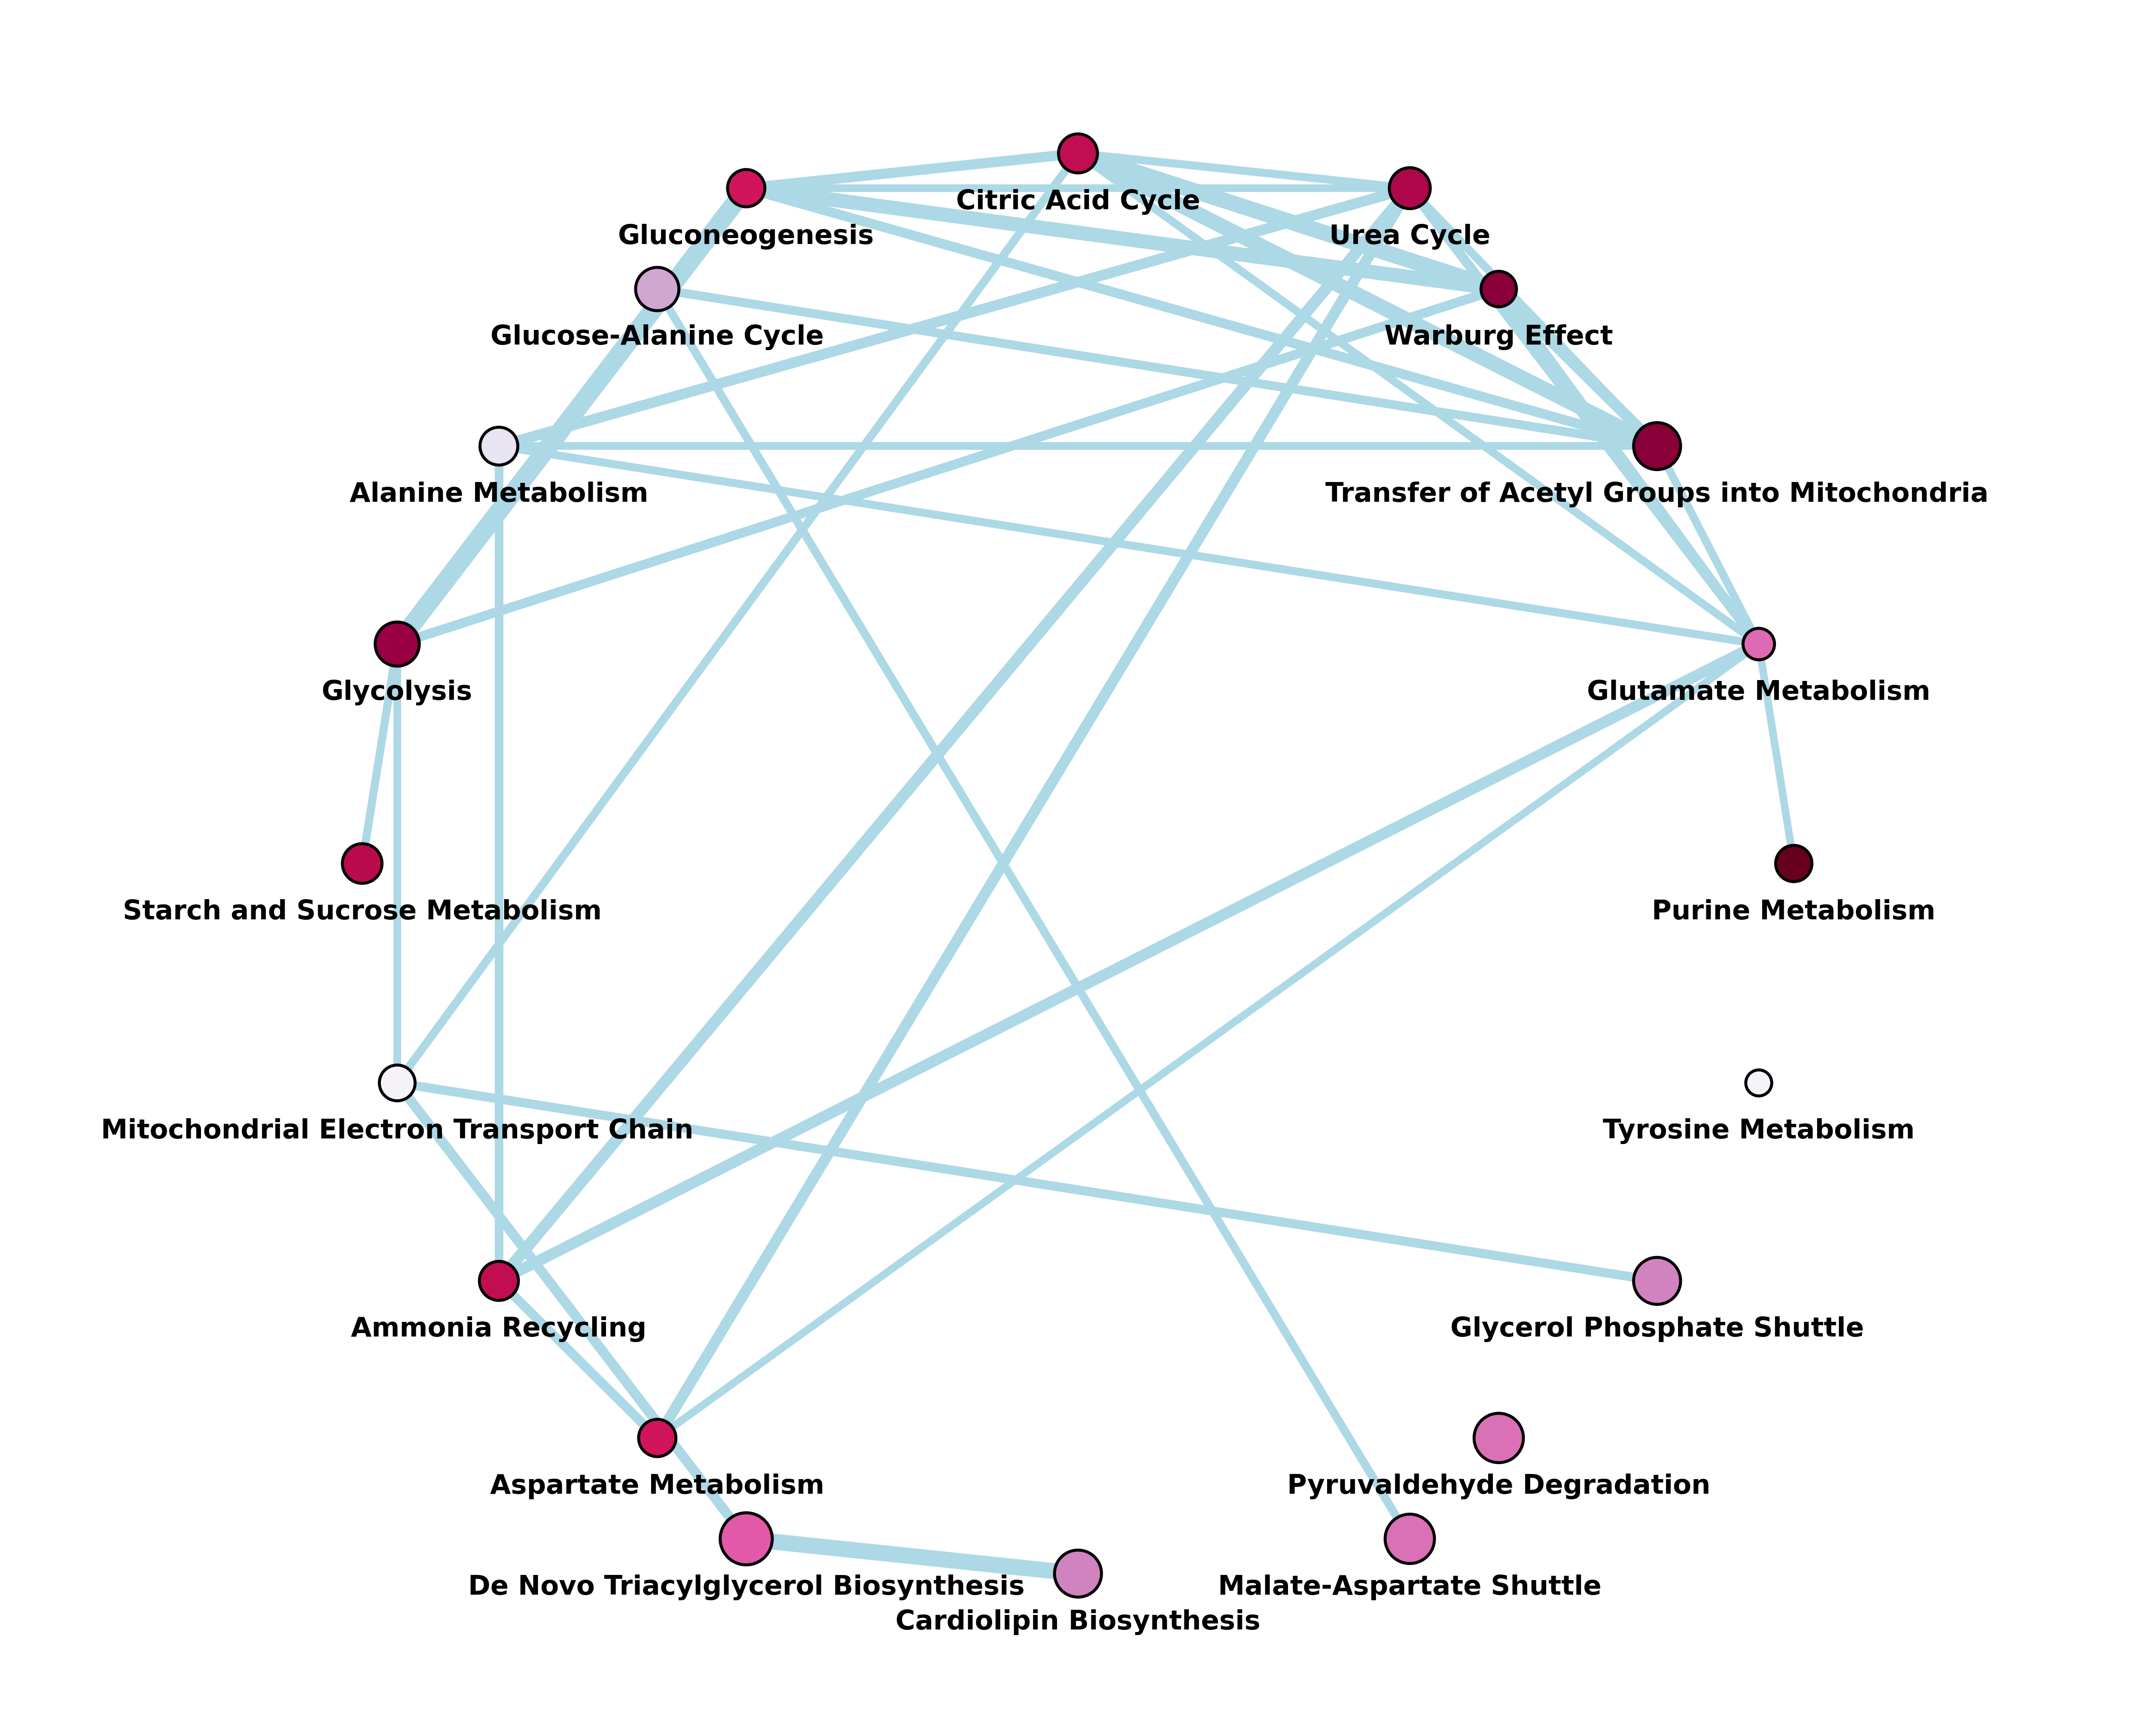

In [16]:
%run ../SAMI/pathway.py
pathway = Pathway('brain2','metabolomics')
pathway.pathway_network(cluster=0,top=20,show=True)

In [23]:
pathway = Pathway('brain2','lipidomics')
pathway.findpathway()
for i in range(30):
    pathway.plot_dot(cluster=i,scale=0.4,height=10,top=20,show=False)

[1] "MetaboAnalyst R objects initialized ..."
[1] "1"                                                                              
[2] "Name matching OK, please inspect (and manual correct) the results then proceed."
[1] "MetaboAnalyst R objects initialized ..."
[1] "1"                                                                              
[2] "Name matching OK, please inspect (and manual correct) the results then proceed."
[1] "MetaboAnalyst R objects initialized ..."
[1] "1"                                                                              
[2] "Name matching OK, please inspect (and manual correct) the results then proceed."
[1] "MetaboAnalyst R objects initialized ..."
[1] "1"                                                                              
[2] "Name matching OK, please inspect (and manual correct) the results then proceed."
[1] "MetaboAnalyst R objects initialized ..."
[1] "1"                                                                           

# Cluster Mapping

In [146]:
cluster_mapping(reference='brain2',query='brain1',reference_data='brain2_pool_1.5.h5ad',query_data='brain1_pool_1.2.h5ad',size=60,show=False)